<a href="https://colab.research.google.com/github/retuyu88/digitalentkominfo/blob/master/Copy_of_%5B30_4%5D_Autoencoder_Coloring_ADF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://i.imgur.com/UjutVJd.jpg" align = "center">

# Colorization AutoEncoder

The autoencoder is trained with grayscale images as input and colored images as output. 

Colorization autoencoder can be treated like the opposite of denoising autoencoder. Instead of removing noise, colorization adds noise (color) to the grayscale image.

Grayscale Images --> Colorization --> Color Images

<img src="https://miro.medium.com/max/1838/1*nmnm2rRJjaBD1TCUgL4dmA.png" height=200 />

In [0]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

# load the CIFAR10 data

In [2]:
(x_train, _), (x_test, _) = cifar10.load_data()


print('X_train.shape =',x_train.shape)
print('X_test.shape  =',x_test.shape)

170500096/170498071 [==============================] - 5s 0us/step
X_train.shape = (50000, 32, 32, 3)
X_test.shape  = (10000, 32, 32, 3)


In [0]:
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

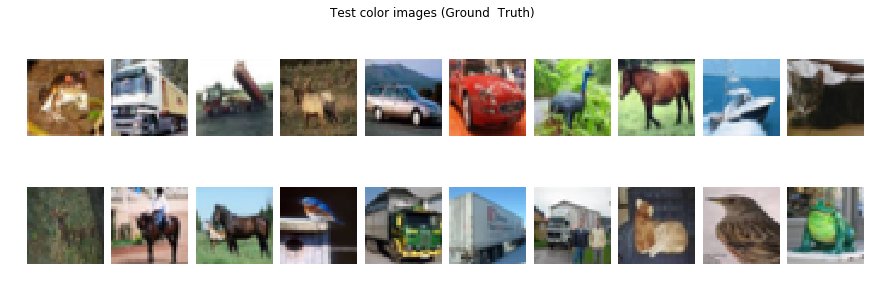

In [4]:
fig, ax = plt.subplots(2,10,figsize=(15,4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,2):
    for i in range(0, 10):
        ax[j,i].imshow(x_train[i+j*10])
        ax[j,i].axis('off')
        
fig.suptitle('Test color images (Ground  Truth)')
plt.show()

# Input Grayscale Images

In [0]:
# convert from color image (RGB) to grayscale
# source: opencv.org
# grayscale = 0.299*red + 0.587*green + 0.114*blue
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


In [0]:
# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

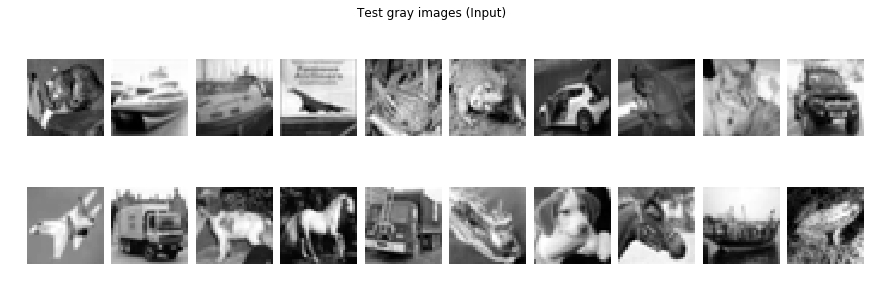

In [7]:
fig, ax = plt.subplots(2,10,figsize=(15,4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,2):
    for i in range(0, 10):
        ax[j,i].imshow(x_test_gray[i+j*10], cmap='gray')
        ax[j,i].axis('off')
        
fig.suptitle('Test gray images (Input)')
plt.show()

# Normalize Dataset

In [0]:
# normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

# reshape images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

# reshape images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)


# Ecoder Model
 build the encoder model

In [9]:
# network parameters
input_shape = (img_rows, img_cols, 1)
latent_dim = 256



inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
x = Conv2D(64, 3,strides=2, activation='relu', padding='same')(x)
x = Conv2D(128, 3,strides=2, activation='relu', padding='same')(x)
x = Conv2D(256, 3,strides=2, activation='relu', padding='same')(x)


# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)

# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

W0809 03:33:08.776814 139792999634816 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________

# Decoder Model
 build the decoder model

In [10]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)


# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
x = Conv2DTranspose(256, 3,strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(128, 3,strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(64, 3,strides=2, activation='relu', padding='same')(x)

outputs = Conv2DTranspose(channels,3, activation='sigmoid', padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              1052672   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731

# Autoencoder = Encoder + Decoder
instantiate autoencoder model

In [11]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 256)               1418496   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


# Compile Model

* create checkpoint to reduce learning rate by sqrt(0.1) if the loss does not improve in 3 epochs
* compile using Mean Square Error (MSE) loss function, Adam optimizer

In [0]:

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=3,
                               verbose=1,
                               min_lr=0.5e-6)
callbacks = [lr_reducer]


autoencoder.compile(loss='mse', optimizer='adam')



# Training
train the autoencoder

In [14]:
batch_size = 256
epochs=20

autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 15s 309us/sample - loss: 0.0264 - val_loss: 0.0152
Epoch 2/20
50000/50000 [==============================] - 12s 235us/sample - loss: 0.0136 - val_loss: 0.0121
Epoch 3/20
50000/50000 [==============================] - 12s 241us/sample - loss: 0.0112 - val_loss: 0.0106
Epoch 4/20
50000/50000 [==============================] - 12s 236us/sample - loss: 0.0102 - val_loss: 0.0097
Epoch 5/20
50000/50000 [==============================] - 12s 231us/sample - loss: 0.0095 - val_loss: 0.0092
Epoch 6/20
50000/50000 [==============================] - 12s 230us/sample - loss: 0.0089 - val_loss: 0.0088
Epoch 7/20
50000/50000 [==============================] - 11s 228us/sample - loss: 0.0086 - val_loss: 0.0088
Epoch 8/20
50000/50000 [==============================] - 11s 229us/sample - loss: 0.0082 - val_loss: 0.0085
Epoch 9/20
50000/50000 [==============================] - 12s 230us/sample - l

# Predict
predict the autoencoder output from test data

In [0]:
x_decoded = autoencoder.predict(x_test_gray)

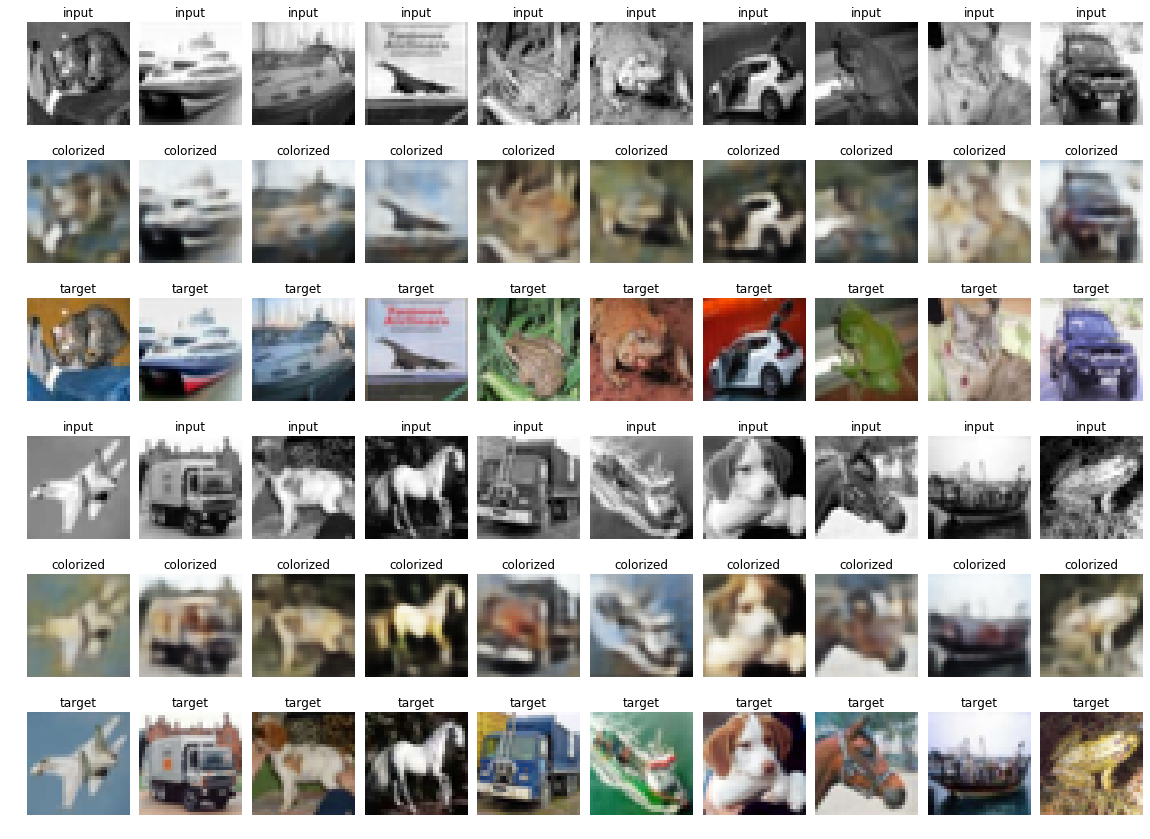

In [16]:
fig, ax = plt.subplots(6,10,figsize=(20,15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
k=2
for j in range(0,2):
    for i in range(0, 10):
        ax[j+k-2,i].imshow(x_test_gray[i+j*10,:,:,0], cmap='gray')
        ax[j+k-2,i].set_title('input')
        ax[j+k-2,i].axis('off')
        ax[j+k-1,i].imshow(x_decoded[i+j*10])
        ax[j+k-1,i].set_title('colorized')
        ax[j+k-1,i].axis('off')
        ax[j+k,i].imshow(x_test[i+j*10])
        ax[j+k,i].set_title('target')
        ax[j+k,i].axis('off')
    k+=2
        
plt.show()

<p>Copyright &copy; 2019 <a href=https://www.linkedin.com/in/andityaarifianto/>ADF</a> </p>